# 配对交易 -- pair trading

股价变化stationay
股价变化 Non-Stationay的时候
1；差分（观察股价变化率，一介）
2：协整，相对stationay，满足一定的线性关系(aX + bY = c)
策略关键，找到相关关系

判断股价是否stationary
AR：auto regression 拿昨天的自己预测今天的自己
unit root单位根检验：y(t) = b+cy(t-1)+a（随机数） 
看b是否等于1，如果b=1，则认为y是non-stationary的，因为此时y的股价需要根据前一天的股价加上另外一个随机数才能得到，不可预测
DF检验：判断c>1 or 0<c<1
0<c<1 则认为是收敛的，c>1则认为是发散的
ADF检验：高阶自回归，以多天前的数据预测今天

In [1]:
import pandas as pd 
import numpy as np
import tushare as ts
import seaborn as sns
import matplotlib.pyplot as plt
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
stocks_pair=['600199','600702']

## 数据准备&回测准备

In [2]:
data1 = ts.get_k_data('600199','2018-01-01','2019-05-31')[['date','close']]
data1.head()

,date,close
0,2018-01-02,7.758
1,2018-01-03,7.808
2,2018-01-04,7.897
3,2018-01-05,7.847
4,2018-01-08,7.897


In [9]:
data2 = ts.get_k_data('600702','2018-01-01','2019-05-31')['close']
data2.head()

0    45.771
1    45.442
2    45.861
3    45.242
4    43.874
Name: close, dtype: float64

In [10]:
data = pd.concat([data1, data2], axis=1)     #数据拼接
data.head()

,date,close,close
0,2018-01-02,7.758,45.771
1,2018-01-03,7.808,45.442
2,2018-01-04,7.897,45.861
3,2018-01-05,7.847,45.242
4,2018-01-08,7.897,43.874


In [11]:
data.set_index('date', inplace=True)
data.columns = stocks_pair

In [12]:
data.head()

,600199,600702
date,,
2018-01-02,7.758,45.771
2018-01-03,7.808,45.442
2018-01-04,7.897,45.861
2018-01-05,7.847,45.242
2018-01-08,7.897,43.874


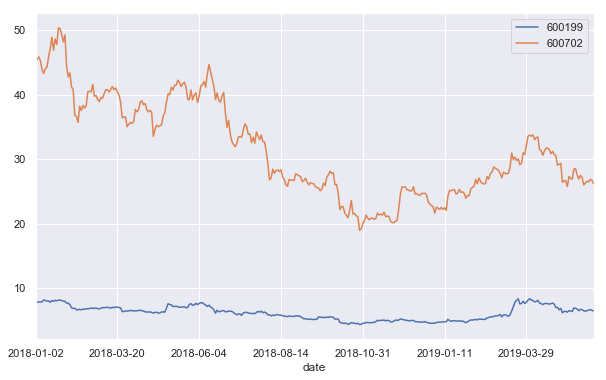

In [15]:
sns.set()
data.plot(figsize=(10,6))

## 策略开发

In [16]:
data['priceDelta'] = data['600199']-data['600702']    #计算价差

Text(0, 0.5, 'Spread')

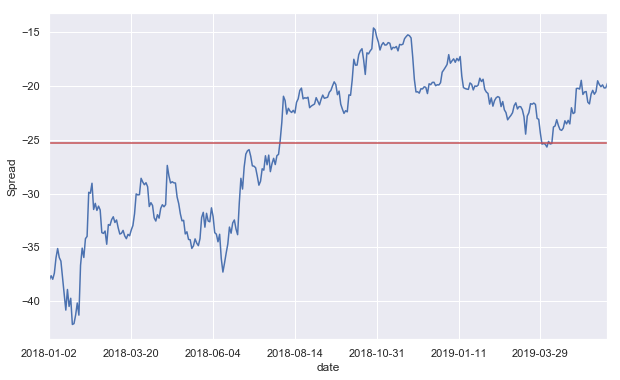

In [17]:
data['priceDelta'].plot(figsize=(10,6))             #将价差跟均值画出来
plt.axhline(data['priceDelta'].mean(), color='r')
plt.ylabel('Spread')

In [18]:
data['zscore'] = (data['priceDelta']-data['priceDelta'].mean())/np.std(data['priceDelta'])      #归一化差值，跟标准差做比较

In [19]:
data.head(10)

,600199,600702,priceDelta,zscore
date,,,,
2018-01-02,7.758,45.771,-38.013,-1.895535
2018-01-03,7.808,45.442,-37.634,-1.838919
2018-01-04,7.897,45.861,-37.964,-1.888215
2018-01-05,7.847,45.242,-37.395,-1.803218
2018-01-08,7.897,43.874,-35.977,-1.591397
2018-01-09,8.187,43.295,-35.108,-1.461585
2018-01-10,8.097,44.044,-35.947,-1.586915
2018-01-11,8.007,44.284,-36.277,-1.636211
2018-01-12,8.017,45.871,-37.854,-1.871783


In [20]:
data[data['zscore']< -1.5].head(10)  #选出价差超过1.5个标准差的日期

,600199,600702,priceDelta,zscore
date,,,,
2018-01-02,7.758,45.771,-38.013,-1.895535
2018-01-03,7.808,45.442,-37.634,-1.838919
2018-01-04,7.897,45.861,-37.964,-1.888215
2018-01-05,7.847,45.242,-37.395,-1.803218
2018-01-08,7.897,43.874,-35.977,-1.591397
2018-01-10,8.097,44.044,-35.947,-1.586915
2018-01-11,8.007,44.284,-36.277,-1.636211
2018-01-12,8.017,45.871,-37.854,-1.871783
2018-01-15,7.828,47.159,-39.331,-2.092417


In [21]:
len(data[data['zscore']< -1.5])   

24

## 产生交易信号

In [22]:
data['position_1'] = np.where(data['zscore'] >1.5, -1,np.nan)
data['position_1'] = np.where(data['zscore'] <-1.5, 1,data['position_1'])
data['position_1'] = np.where(abs(data['zscore'])<0.5 ,0,data['position_1'])

In [23]:
data.head(50)

,600199,600702,priceDelta,zscore,position_1
date,,,,,
2018-01-02,7.758,45.771,-38.013,-1.895535,1.0
2018-01-03,7.808,45.442,-37.634,-1.838919,1.0
2018-01-04,7.897,45.861,-37.964,-1.888215,1.0
2018-01-05,7.847,45.242,-37.395,-1.803218,1.0
2018-01-08,7.897,43.874,-35.977,-1.591397,1.0
2018-01-09,8.187,43.295,-35.108,-1.461585,NaN
2018-01-10,8.097,44.044,-35.947,-1.586915,1.0
2018-01-11,8.007,44.284,-36.277,-1.636211,1.0
2018-01-12,8.017,45.871,-37.854,-1.871783,1.0


In [24]:
data['position_1'] = data['position_1'].ffill()

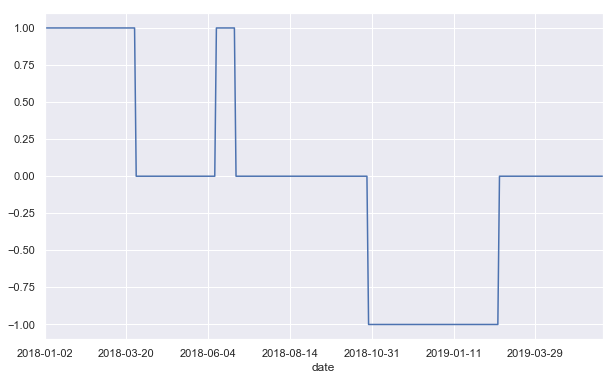

In [26]:
data['position_1'].plot(figsize=(10,6))

In [27]:
data['position_2'] =-1*np.sign(data['position_1'])

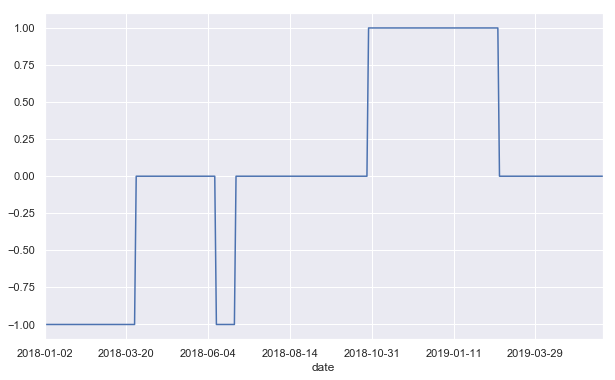

In [28]:
data['position_2'].plot(ylim=[-1.1, 1.1], figsize=(10,6))

## 计算策略收益并可视化

In [29]:
data['return_1'] = np.log(data['600199']/data['600199'].shift(1))
data['return_2'] = np.log(data['600702']/data['600702'].shift(1))

In [30]:
data['strategy'] = 0.5*data['position_1'].shift(1)*data['return_1']+0.5*data['position_2'].shift(1)*data['return_2']  #假设各持仓一半

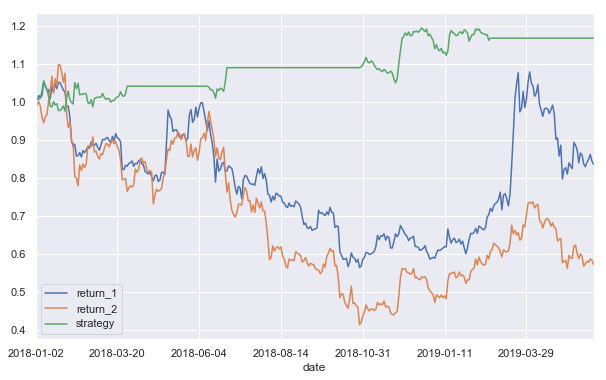

In [31]:
data[['return_1','return_2','strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))